**Team Members:** Ethan Flores, Hayden Dinh, Adrian Apsay, Zander Vilaysane, Hieu Pham, Sadrac Santacruz

**Link to our dataset:** https://www.kaggle.com/datasets/kaggleashwin/vehicle-type-recognition

**Click on Milestones**: <br>
[Milestone 2: Data Exploration & Initial Preprocessing](#milestone-2-data-exploration-initial-preprocessing)<br>
[Milestone 3: Preprocessing & Baseline/First Model](#milestone-3-preprocessing-baseline-model)<br>

<a id='milestone-2-data-exploration-initial-preprocessing'></a> <br>
# Milestone 2: Data Exploration & Initial Preprocessing

In [117]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import torch
import sklearn
from PIL import Image


Number of Classes: 4
Total number of Images: 400


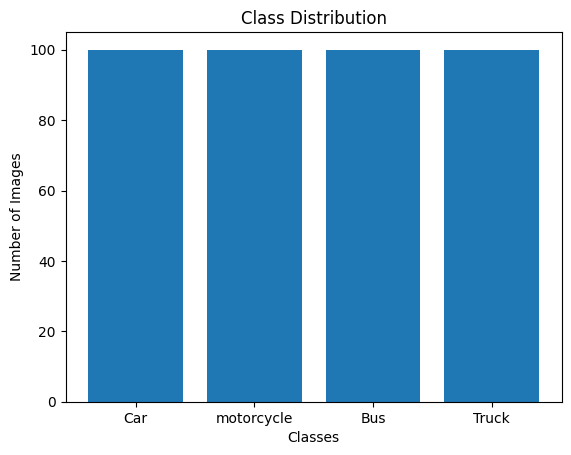

In [118]:
# Plot example classes of the image
image_dir = "Dataset"
image_classes = os.listdir(image_dir)

num_classes = len(image_classes)
num_images = sum(len(os.listdir(os.path.join(image_dir, cls))) for cls in image_classes)

print(f"Number of Classes: {num_classes}")
print(f"Total number of Images: {num_images}")

class_distribution = {cls: len(os.listdir(os.path.join(image_dir, cls))) for cls in image_classes}
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

As we see here, we have an even distribution of images within each folder for all classes

In [119]:
image_paths = []
folder_path = 'Dataset'

output_dct = {}
for vehicle in ['Bus', 'Car', 'motorcycle', 'Truck']:
    vehicle_folder = os.path.join(folder_path, vehicle)
    image_dimensions = []

    for img in os.listdir(vehicle_folder):
        img_path = os.path.join(vehicle_folder, img)

        with Image.open(img_path) as img:
            width, height = img.size
            image_dimensions.append((width, height))

    output_dct[vehicle] = image_dimensions

dimension_df = pd.DataFrame(output_dct)

In [120]:
for col in dimension_df.columns:
    num_unique = dimension_df[col].nunique()
    print(f'Number of unique image dimensions for {col}: {num_unique}')

Number of unique image dimensions for Bus: 82
Number of unique image dimensions for Car: 71
Number of unique image dimensions for motorcycle: 74
Number of unique image dimensions for Truck: 78


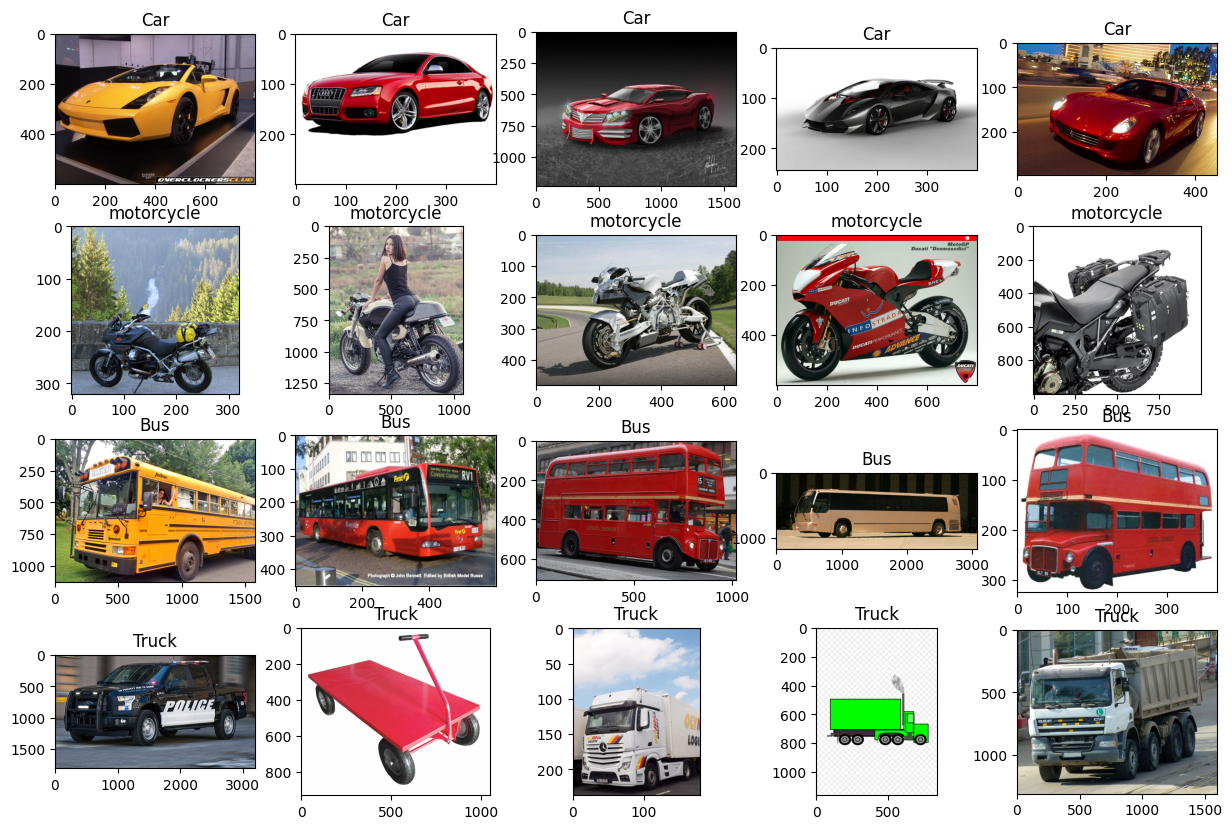

In [121]:
# example images for each class
image_dir = "Dataset"
image_classes = os.listdir(image_dir)
def display_samples(image_dir, num_samples=5):
    plt.figure(figsize=(15, 10))
    for cls in image_classes:
        sample_images = np.random.choice(os.listdir(os.path.join(image_dir, cls)), num_samples, replace=False)
        # print(sample_images)
        for i, img_name in enumerate(sample_images):
            img_path = os.path.join(image_dir, cls, img_name)
            img = Image.open(img_path)
            plt.subplot(len(image_classes), num_samples, i + 1 + image_classes.index(cls) * num_samples)
            plt.imshow(img)
            plt.title(cls)
    plt.show()

display_samples(image_dir)

As we can see when we plotted example images for each class above, a lot of them have different dimensions, in terms of sizing. In our preprocessing step, we are going to have to standardize the sizing of each image.

In [122]:
image_classes

['Car', 'motorcycle', 'Bus', 'Truck']

<a id='milestone-3-preprocessing-baseline-model'></a> <br>
# Milestone 3: Preprocessing & Baseline Model

Below, we are scaling, grayscaling, and rotating our images for preprocessing and data augmentation (as there aren't a lot of images per class, with all being capped at 100 per class).

## Final Preprocessing, Data Augmentation

In [123]:
all_images = []
all_labels = []

In [124]:
import random
from random import sample

# function we define to display augmented data later
def display_sample_images(images, labels, num_samples=5, is_grayscale=False):
    sampled_images = sample(list(zip(images, labels)), num_samples)

    plt.figure(figsize=(15, 10))
    for i, img_and_label in enumerate(sampled_images):
        img = img_and_label[0]
        label = img_and_label[1]
        plt.subplot(1, num_samples, i + 1)
        if is_grayscale:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

### Image Scaling

In [125]:
target_size = (224, 224)

scaled_images = []
scaled_labels = []

for cls in image_classes:
    folder_path = os.path.join(image_dir, cls)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        with Image.open(img_path) as img:
            scaled_img = img.resize(target_size)
            scaled_images.append(scaled_img)
            scaled_labels.append(cls)

all_images = all_images + scaled_images
all_labels = all_labels + scaled_labels

In [126]:
print(len(all_images))
print(len(all_labels))

400
400


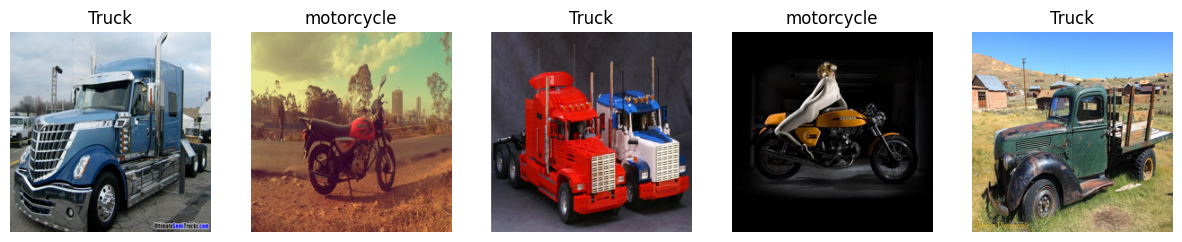

In [127]:
display_sample_images(scaled_images, scaled_labels)

### Grayscaling (the scaled images)

In [128]:
grayscale_images = []
grayscale_labels = []
for i in range(len(scaled_images)):
    grayscaled_img = scaled_images[i].convert('L')
    grayscale_images.append(grayscaled_img)
    grayscale_labels.append(scaled_labels[i])

all_images = all_images + grayscale_images
all_labels = all_labels + grayscale_labels

/Users/adrianapsay/cse151a/CSE151A_Final_Project/env/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [129]:
print(len(all_images))
print(len(all_labels))

800
800


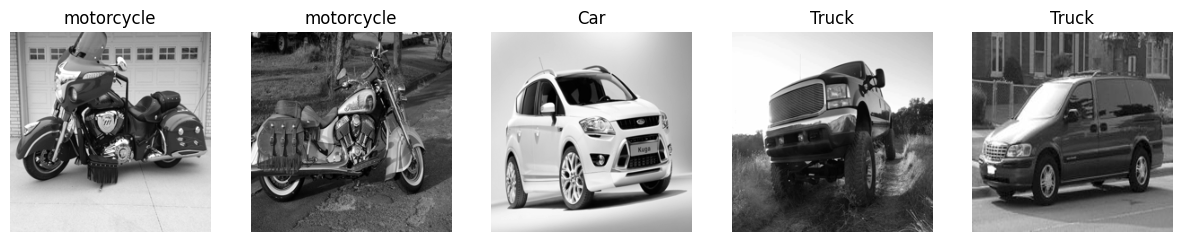

In [130]:
display_sample_images(grayscale_images, grayscale_labels, is_grayscale=True)

### Rotating Images (both non-grayscale and grayscale)
*note*: it's not realistic seeing a car image at an angle past 90 degrees (anything past 90 will result in a car being upside down), so the data will vary from angles 15, 30, 45, 60, 75.

In [131]:
angles = [15, 30, 45, 60, 75]
rotated_images = []
rotated_labels = []

# non grayscaled images for rotation
for i in range(len(scaled_images)):
    angle = np.random.choice(angles)
    rotated_img = scaled_images[i].rotate(angle)
    rotated_images.append(rotated_img)
    rotated_labels.append(scaled_labels[i])

# grayscaled images for rotation
for i in range(len(grayscale_images)):
    angle = np.random.choice(angles)
    rotated_grayscale_img = grayscale_images[i].rotate(angle)
    rotated_images.append(rotated_grayscale_img)
    rotated_labels.append(grayscale_labels[i])

all_images = all_images + rotated_images
all_labels = all_labels + rotated_labels

In [132]:
print(len(all_images))
print(len(all_labels))

1600
1600


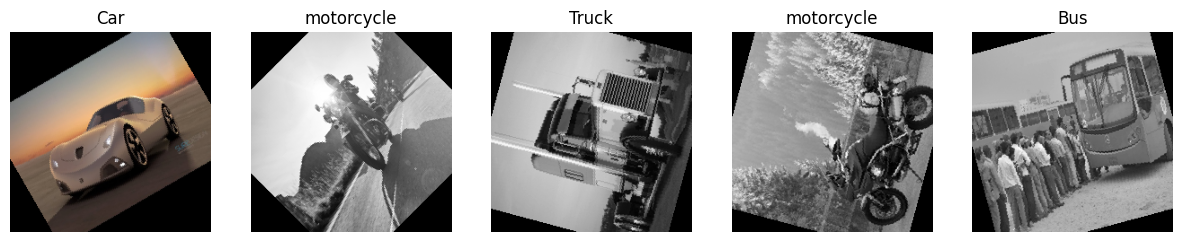

In [133]:
display_sample_images(rotated_images, rotated_labels, is_grayscale=True)

### Horizontally Flipping Images (non-grayscale and grayscale)
*note*: it's not realistic to see vehicles flipped upside down, so we're only flipping horizontally for our data augmentation.

In [134]:
flipped_images = []
flipped_labels = []

# non-grayscale
for i in range(len(scaled_images)):
    flipped_img = scaled_images[i].transpose(Image.FLIP_LEFT_RIGHT)
    flipped_images.append(flipped_img)
    flipped_labels.append(scaled_labels[i])

# grayscale
for i in range(len(grayscale_images)):
    flipped_grayscale_img = grayscale_images[i].transpose(Image.FLIP_LEFT_RIGHT)
    flipped_images.append(flipped_grayscale_img)
    flipped_labels.append(grayscale_labels[i])

all_images = all_images + flipped_images
all_labels = all_labels + flipped_labels


In [135]:
print(len(all_images))
print(len(all_labels))

2400
2400


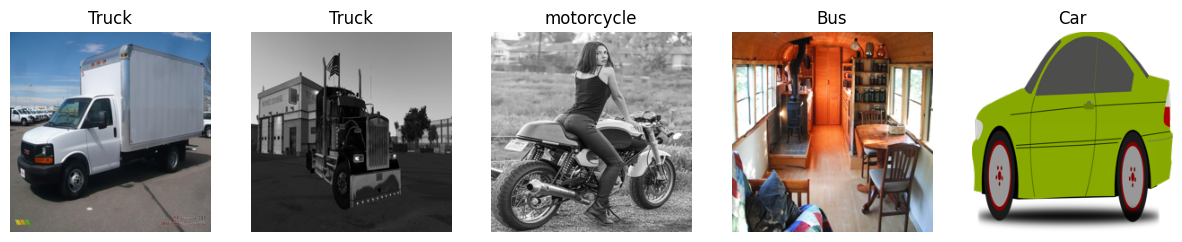

In [136]:
display_sample_images(flipped_images, flipped_labels, is_grayscale=True)

In [147]:
# all_images

In [148]:
# all_labels

## Feature Extraction (images to embeddings using Resnet50 Neural Net)

In [139]:
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm

# pre-trained ResNet50 model we are using to extract embeddings
resnet50model = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50model = torch.nn.Sequential(*list(resnet50model.children())[:-1])
resnet50model.eval()

# normalize data for resnet-pretrained models (improves model training performance)
normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # already scaled so i dont think we need it but documentation recommended it
    transforms.Lambda(lambda img: img.convert("RGB")), # resnet50 only takes in images of rgb format
    transforms.ToTensor(),
    normalize
])

def preprocess_tensor(img):
    return transform(img)

# extract embeddings from the images
def extract_embeddings(images, model):
    embeddings = []
    with torch.no_grad():
        for img in tqdm(images, desc="Extracting embeddings"):
            tensor_img = preprocess_tensor(img).unsqueeze(0)  # add batch dimension (resnet50 needs this dimension)
            embedding = model(tensor_img).squeeze().numpy()  # get the output embedding
            embeddings.append(embedding)
    return embeddings

all_embeddings = extract_embeddings(all_images, resnet50model)

np.save("image_embeddings.npy", np.array(all_embeddings))
np.save("image_labels.npy", np.array(all_labels))


Extracting embeddings: 100%|██████████| 2400/2400 [01:02<00:00, 38.13it/s]


In [140]:
all_embeddings[10]

array([0.09531469, 0.        , 0.14875893, ..., 0.        , 0.        ,
       0.00364926], dtype=float32)

## Baseline Model
*Note*: This is our initial baseline model, and we decided to use Multi-Class Support Vector Machines to solve our use-case. Eventually, we will also be using CNN's.

### Load Data, Prepare Split

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [142]:
image_embeddings = np.load("image_embeddings.npy")
image_labels = np.load("image_labels.npy")

In [143]:
# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(image_embeddings, image_labels, test_size=0.2, random_state=42)

### Using Multi-Class SVM ('ovr'), Accuracy Results on Training and Testing

In [144]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train the multi-class SVM
svm = SVC(kernel='linear', decision_function_shape='ovr')
svm.fit(X_train_scaled, y_train)

# predict on training set

train_predictions = svm.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, train_predictions)
train_error = 1 - train_accuracy
print(f"Accuracy: {train_accuracy}")
print(classification_report(y_train, train_predictions))

Accuracy: 1.0
              precision    recall  f1-score   support

         Bus       1.00      1.00      1.00       476
         Car       1.00      1.00      1.00       481
       Truck       1.00      1.00      1.00       499
  motorcycle       1.00      1.00      1.00       464

    accuracy                           1.00      1920
   macro avg       1.00      1.00      1.00      1920
weighted avg       1.00      1.00      1.00      1920



In [145]:
# predict on testing set
test_predictions = svm.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)
test_error = 1 - test_accuracy
print(f"Accuracy: {test_accuracy}")
print(classification_report(y_test, test_predictions))

Accuracy: 0.9854166666666667
              precision    recall  f1-score   support

         Bus       0.98      0.97      0.98       124
         Car       1.00      0.99      1.00       119
       Truck       0.95      0.98      0.97       101
  motorcycle       1.00      1.00      1.00       136

    accuracy                           0.99       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.99      0.99      0.99       480



### View What Models Tend to Under/Overfit

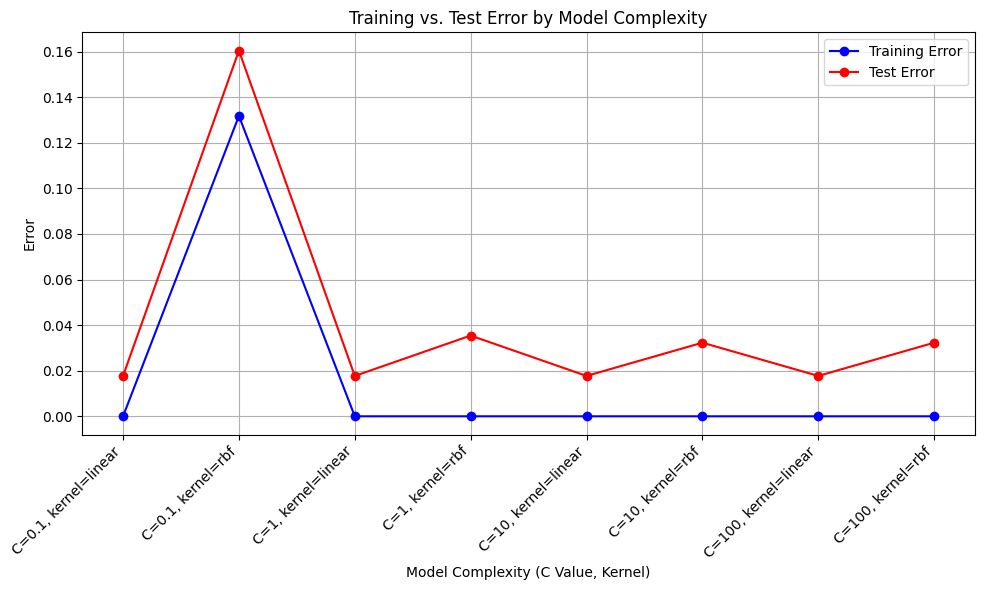

In [146]:
from sklearn.model_selection import GridSearchCV

# testing different hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']
}

# grid search cross-validation to find best hyperparameters for SVM
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

# get results, mean-train and mean-test errors
results = grid_search.cv_results_
mean_train_errors = 1 - np.array(results['mean_train_score'])
mean_test_errors = 1 - np.array(results['mean_test_score'])


# plot to see over/underfitting
x_labels = []
for params in results['params']:
    x_labels.append(f"C={params['C']}, kernel={params['kernel']}")

plt.figure(figsize=(10, 6))
plt.plot(mean_train_errors, label="Training Error", color='blue', marker='o')
plt.plot(mean_test_errors, label="Test Error", color='red', marker='o')
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=45, ha='right')
plt.title("Training vs. Test Error by Model Complexity")
plt.xlabel("Model Complexity (C Value, Kernel)")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
